In [1]:
! pip install pyhdf
! apt-get install -qq libgdal-dev libproj-dev
! pip install --no-binary shapely shapely --force
! pip install cartopy
! pip install pynufft

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 703 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 198 kB 4.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shapely: filename=Shapely-1.8.2-cp37-cp37m-linux_x86_64.whl size=668910 sha256=dd811739a98c4c89bd2546321f3c1addf138494474e080cd3be6936ad40d80da
  Stored in directory: /root/.cache/pip/wheels/2f/9e/07/e9e90942b4e31275785d2f7e455607bfe876e53906307f80cd
Successfully built shapely
  Attempting uninstall: shapely
    Found existing installation: Shapely 1.8.2
    Uninstalling Shapely-1.8.2:
      Successfully uninstalled Shapely-1.8.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |███

In [10]:
from google.colab import drive, data_table
drive.mount('/content/drive', force_remount=True)
# data_table.enable_dataframe_formatter()

import os
import pdb
import time
import glob
import h5py
import math
import timeit
import numba
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib as mpl
from pynufft import NUFFT
import cartopy.crs as ccrs
import cartopy.feature as cf
from pandas._libs import index
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pyhdf.HDF import *
from pyhdf.V   import *
from pyhdf.VS  import *
from pyhdf.SD  import *

Mounted at /content/drive


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
def plot_as_me(ds, channel, axes, qt, wl, signal_mode, attrs, save_fig=False, **kwargs):
  cmap = mpl.cm.jet
  bounds = np.linspace(0, 100, 64)
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

  #plot.title1('{instr} {mode} {qt} at {wl} {wlu}'.format(instr=attrs['system'],
  #                                                           mode=signal_mode,
  #                                                           qt=qt,
  #                                                           wl=wl,
  #                                                           wlu='nm'), coef=2.2)
  # plot.title2(str(ds.time.values[0].astype('datetime64[D]')), coef=2.2)

  # plot.title3('{} ({:.1f}N, {:.1f}E)'.format(attrs['site_location'], 
  #                                          float(attrs['geospatial_lat_min']), 
  #                                          float(attrs['geospatial_lon_min'])), coef=2.2)
  
  q = ds[:, ds.range<14000].plot.pcolormesh(x='time', 
                 y='range', 
                 cmap='jet', 
                 vmin=kwargs['vmin'], 
                 vmax=kwargs['vmax'],
                 # norm=norm
                 )
  myFmt = mdates.DateFormatter('%H:%M')
  axes.xaxis.set_major_formatter(myFmt)

  plot.gapsizer(axes, ds.time.values, ds.range, gapsize=5, colour='#c7c7c7')
  axes.set_xlim([ds.time[0].values.astype('datetime64[D]'), ds.time[0].values.astype('datetime64[D]')+np.timedelta64(1,'D')])
  # q.cmap.set_over('white')
  if save_fig:
    year, month, day = str(ds.time[0].values.astype('datetime64[D]')).split('-') 
    out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
    fl_name = '{instru}_{qt}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=attrs['system'], qt=qt, wl=wl, mode=signal_mode, y=year, m=month, d=day)
    fl_name = os.path.join(out_dir, fl_name)
    plt.savefig(fl_name, dpi=200)

# Load data

In [13]:
# filename = '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Óptica de Fourier/CAL_LID_L1-Standard-V4-11.2020-07-01T19-02-25ZD_Subset.hdf'
filename = '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Óptica de Fourier/CAL_LID_L1-Standard-V4-11.2020-07-01T08-24-53ZN_Subset.hdf'
# filename = '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Óptica de Fourier/CAL_LID_L1-Standard-V4-11.2020-07-01T23-11-35ZN_Subset.hdf'

In [14]:
hdf = SD(filename, SDC.READ)
hdf

In [15]:
hdf.attributes()


{'Subsetter_history': '2022-06-13T15:38:59 -0400 SubsetCalipso ',
 'Subsetter_institution': 'Atmospheric Science Data Center (ASDC) http://eosweb.larc.nasa.gov ',
 'Subsetter_source': 'CAL_LID_L1-Standard-V4-11.2020-07-01T08-24-53ZN.hdf ',
 'Subsetter_spatialFilter': 'none ',
 'Subsetter_temporalFilter': '2020-07-01T00:00:00.000000Z to 2020-07-01T23:59:59.999999Z ',
 'Subsetter_title': 'ASDC CALIPSO Subset ',
 'Subsetter_version': '2.5.b1 '}

In [16]:
keys = hdf.datasets().keys()
keys

dict_keys(['Latitude', 'Longitude', 'Profile_Time', 'Profile_UTC_Time', 'Day_Night_Flag', 'GMAO_Surface_Elevation', 'IGBP_Surface_Type', 'Land_Water_Mask', 'Off_Nadir_Angle', 'Profile_ID', 'QC_Flag', 'QC_Flag_2', 'Snow_Ice_Surface_Type', 'Surface_Elevation', 'Calibration_Constant_532', 'Calibration_Constant_Uncertainty_532', 'Depolarization_Gain_Ratio_532', 'Depolarization_Gain_Ratio_Uncertainty_532', 'Laser_Energy_532', 'Molecular_Number_Density', 'Noise_Scale_Factor_532_Parallel', 'Noise_Scale_Factor_532_Perpendicular', 'Ozone_Number_Density', 'Parallel_Amplifier_Gain_532', 'Parallel_Background_Monitor_532', 'Perpendicular_Amplifier_Gain_532', 'Perpendicular_Background_Monitor_532', 'Parallel_RMS_Baseline_532', 'Perpendicular_Attenuated_Backscatter_532', 'Perpendicular_RMS_Baseline_532', 'Total_Attenuated_Backscatter_532'])

In [17]:
Tab532 = hdf.select('Total_Attenuated_Backscatter_532')
tab532 = Tab532[:,:]
tab532[:,:].shape

(56040, 583)

In [18]:
range = Tab532.attributes()['valid_range']

smin, smax = range.split("...")
valid_min = float(smin)
valid_max = float(smax)
_FillValue = Tab532.attributes()['fillvalue']

invalid = np.logical_or(tab532 > valid_max,
                        tab532 < valid_min)
invalid = np.logical_or(invalid, tab532 == _FillValue)
tab532[invalid] = np.nan

Tab532.attributes(), tab532

({'fillvalue': -9999.0,
  'format': 'Float_32',
  'units': 'per kilometer per steradian',
  'valid_range': '-0.1...3.3'},
 array([[ 1.39065496e-05,  4.47534785e-06, -1.62077606e-06, ...,
          6.38433539e-06, -1.23817119e-06, -4.61498871e-07],
        [ 1.39067661e-05,  4.47541788e-06, -1.62080141e-06, ...,
          5.69754820e-06,  2.18858031e-06,  1.32820860e-05],
        [ 1.39069825e-05,  4.47548791e-06, -1.62082665e-06, ...,
         -1.38792320e-05,  3.86121110e-06, -7.07324352e-06],
        ...,
        [ 1.27617909e-06, -7.48213415e-06,  5.99423765e-05, ...,
          1.51578424e-05, -5.68946371e-06,  1.25240667e-05],
        [ 1.27612452e-06, -7.48181492e-06,  5.99398227e-05, ...,
          1.65345147e-04,  8.70888925e-06,  1.75690675e-05],
        [ 1.27607018e-06, -7.48149705e-06,  5.99372761e-05, ...,
          3.57085846e-05,  1.13193892e-05,  4.95218483e-05]], dtype=float32))

In [19]:
Time = hdf.select('Profile_Time')
time = Time[:]
time

array([[8.67745502e+08],
       [8.67745502e+08],
       [8.67745502e+08],
       ...,
       [8.67748281e+08],
       [8.67748281e+08],
       [8.67748281e+08]])

In [20]:
Latitude = hdf.select('Latitude')
latitude = Latitude[:]

Longitude = hdf.select('Longitude')
longitude = Longitude[:]

latitude.shape, longitude.shape

((56040, 1), (56040, 1))

In [21]:
surface_elevation = hdf.select('GMAO_Surface_Elevation')
surface_elevation[:]

array([[0.10680333],
       [0.10680336],
       [0.10680338],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]], dtype=float32)

In [22]:
latitude, longitude

(array([[ 54.466324],
        [ 54.463417],
        [ 54.46051 ],
        ...,
        [-64.8511  ],
        [-64.84829 ],
        [-64.84548 ]], dtype=float32), array([[-84.11195 ],
        [-84.11344 ],
        [-84.11493 ],
        ...,
        [ 90.52656 ],
        [ 90.523994],
        [ 90.52143 ]], dtype=float32))

# Project

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naci

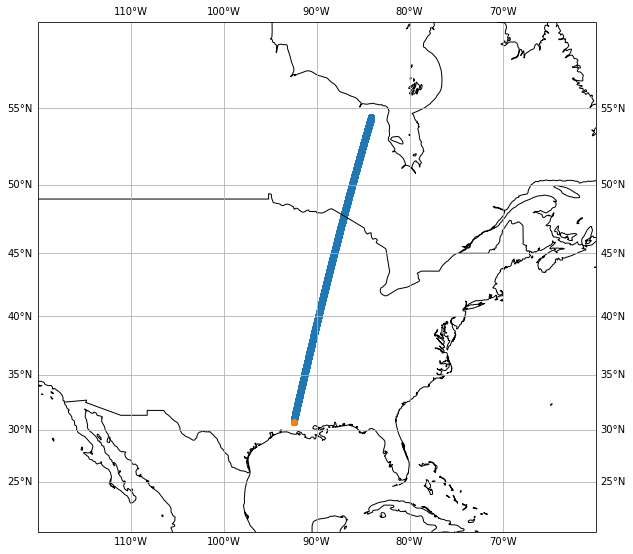

In [23]:
fig = plt.figure(figsize=(10,10))

mrc = ccrs.Mercator()

lim_lons = np.array([-84, -65])
lim_lons = np.array([-179, 179])
lim_lons = np.array([-120, -60])
lim_lats = np.array([-10, 16])
lim_lats = np.array([-89, 89])
lim_lats = np.array([20, 60])

lim_cords = mrc.transform_points(ccrs.PlateCarree(), lim_lons, lim_lats)
x_lim = [lim_cords[0, 0], lim_cords[1, 0]]
y_lim = [lim_cords[0, 1], lim_cords[1, 1]]


postitons = mrc.transform_points(ccrs.PlateCarree(), longitude, latitude)
positions = np.squeeze(postitons)
x = positions[:, 0]
y = positions[:, 1]


ax = plt.axes(projection = ccrs.Mercator())
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS)
# pdb.set_trace()
# i = 5500
I = 8000
ax.scatter(x[:I], y[:I])
ax.scatter(x[I], y[I])

ax.gridlines(draw_labels=True)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
plt.show()


In [24]:
hdf_interface = HDF(filename)
vs_interface  = hdf_interface.vstart()

In [25]:
meta = vs_interface.attach("metadata")
meta

In [26]:
field_infos = meta.fieldinfo()
field_infos

[('Product_ID', 4, 80, 0, 0, 80, 80),
 ('Date_Time_at_Granule_Start', 4, 27, 0, 1, 27, 27),
 ('Date_Time_at_Granule_End', 4, 27, 0, 2, 27, 27),
 ('Initial_Subsatellite_Latitude', 5, 1, 0, 3, 4, 4),
 ('Initial_Subsatellite_Longitude', 5, 1, 0, 4, 4, 4),
 ('Final_Subsatellite_Latitude', 5, 1, 0, 5, 4, 4),
 ('Final_Subsatellite_Longitude', 5, 1, 0, 6, 4, 4),
 ('Rayleigh_Extinction_Cross-section_532', 5, 1, 0, 7, 4, 4),
 ('Rayleigh_Extinction_Cross-section_1064', 5, 1, 0, 8, 4, 4),
 ('Rayleigh_Backscatter_Cross-section_532', 5, 1, 0, 9, 4, 4),
 ('Rayleigh_Backscatter_Cross-section_1064', 5, 1, 0, 10, 4, 4),
 ('Ozone_Absorption_Cross-section_532', 5, 1, 0, 11, 4, 4),
 ('Ozone_Absorption_Cross-section_1064', 5, 1, 0, 12, 4, 4),
 ('Lidar_Data_Altitudes', 5, 583, 0, 13, 2332, 2332),
 ('Met_Data_Altitudes', 5, 33, 0, 14, 132, 132)]

In [27]:
all_data = meta.read(meta._nrecs)[0]
all_data

['L1_LIDAR_Science                                                                ',
 '2020-07-01T08:24:51.556000Z',
 '2020-07-01T09:11:10.981399Z',
 54.46632385253906,
 -84.11195373535156,
 -64.8454818725586,
 90.52143096923828,
 5.167000147288005e-31,
 3.1270001135475393e-32,
 5.929999894672282e-32,
 3.591999964793912e-33,
 2.728461069538629e-25,
 0.0,
 [39.79566955566406,
  39.49628829956055,
  39.19690704345703,
  38.89752197265625,
  38.598140716552734,
  38.29875946044922,
  37.9993782043457,
  37.69999694824219,
  37.40061569213867,
  37.101234436035156,
  36.80185317993164,
  36.502471923828125,
  36.20309066772461,
  35.903709411621094,
  35.60432434082031,
  35.3049430847168,
  35.00556182861328,
  34.706180572509766,
  34.40679931640625,
  34.107418060302734,
  33.80803680419922,
  33.5086555480957,
  33.20927429199219,
  32.90989303588867,
  32.610511779785156,
  32.311126708984375,
  32.01174545288086,
  31.712366104125977,
  31.412982940673828,
  31.113601684570312,
  30.

In [28]:
meta.detach()

In [29]:
data_dictionary = {}
field_name_index = 0

for field_info, data in zip(field_infos, all_data):
  data_dictionary[field_info[field_name_index]] = data
lidar_altitudes = data_dictionary["Lidar_Data_Altitudes"]

In [30]:
dts = [dt.datetime.fromtimestamp(float(t + dt.datetime.timestamp(dt.datetime(year=1993, 
                                                                       month=1, 
                                                                       day=1, 
                                                                       hour=0, 
                                                                       minute=0, 
                                                                       second=0, 
                                                                       microsecond=0)))) for t in time]
# dts

In [31]:
# pdb.set_trace()
pos_labels = ["\n".join((str(longitude[i][0]), str(latitude[i][0]))) for i in np.arange(len(longitude))]
# pos_labels

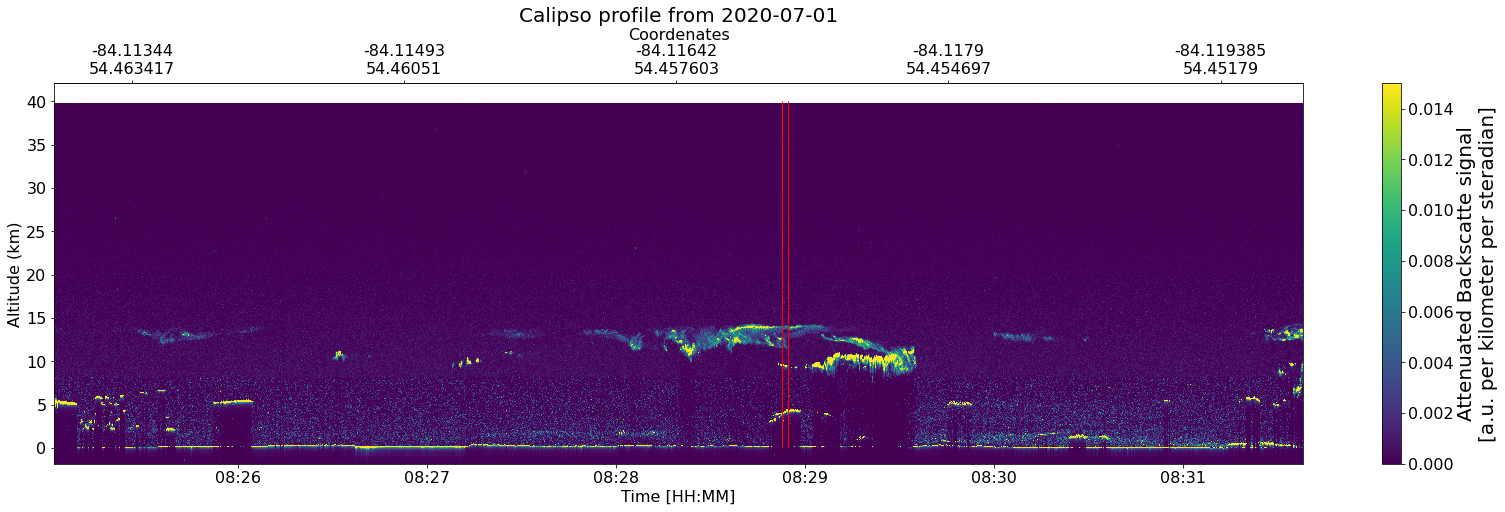

In [32]:
# fig = plt.figure(figsize=(15,6))
fig, ax = plt.subplots(figsize=[28,7])
# pdb.set_trace()
plt.title('Calipso profile from {date}'.format(date=dts[0].date().strftime('%Y-%m-%d')), fontsize=20)

plt.pcolormesh(dts[:I], lidar_altitudes, tab532[:I].T, vmin=0, vmax=0.015)
cbar = plt.colorbar()
cbar.set_label("Attenuated Backscatte signal\n[a.u. per kilometer per steradian]", fontsize=20)
cbar.ax.tick_params(labelsize=16)

i = 4700

secax = ax.secondary_xaxis('top')
secax.set_xlabel('Coordenates', fontsize=16)
secax.set_xticklabels(pos_labels, fontsize=16)

ax.set_xlabel('Time [HH:MM]', fontsize=16)
ax.set_ylabel('Altitude (km)', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)


myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)

# pdb.set_trace()
endTime = dts[4660] + dt.timedelta(seconds=0.1)
start = mpl.dates.date2num(dts[4660])
end = mpl.dates.date2num(endTime)
width = end - start
rect = mpl.patches.Rectangle((start, 0), width, 40, linewidth=1,color='red',fill=False)

ax.add_patch(rect)


endTime = dts[4698] + dt.timedelta(seconds=0.1)
start = mpl.dates.date2num(dts[4698])
end = mpl.dates.date2num(endTime)
width = end - start
rect = mpl.patches.Rectangle((start, 0), width, 40, linewidth=1,color='red',fill=False)

ax.add_patch(rect)



(-0.01, 0.02)

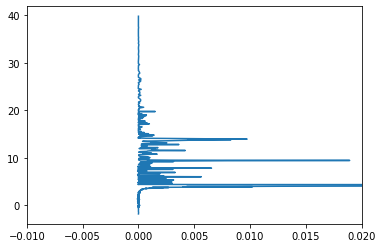

In [ ]:
plt.plot(tab532[i], lidar_altitudes)
plt.xlim([-0.01, 0.02])
# plt.ylim([0, 20])

In [33]:
print(np.isnan(tab532[i]).sum())
tab532[i][np.isnan(tab532[i])] = 0

np.isnan(tab532[i]).sum()

0


0

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


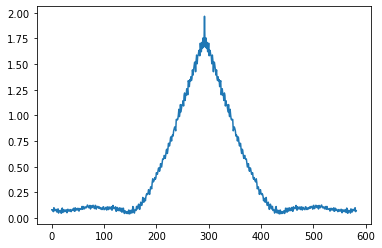

In [34]:
FT_profile = np.fft.fftshift(tab532[i])
FT_profile = np.fft.fft(FT_profile)
FT_profile = np.fft.ifftshift(FT_profile)
# pdb.set_trace()
# n = np.shape(lidar_altitudes)
# dx =
# freqs = np.fft.fftfreq(lidar_altitudes)

spec_profile = np.sqrt(FT_profile * np.conjugate(FT_profile))
spec_profile

plt.plot(spec_profile)

0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


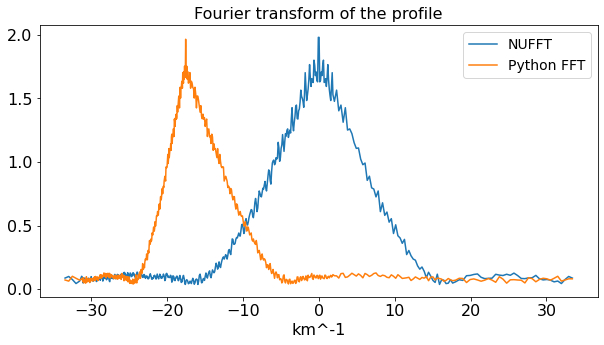

In [35]:
print(np.isnan(tab532[i]).sum())
tab532[i][np.isnan(tab532[i])] = 0

np.isnan(tab532[i]).sum()

NufftObj = NUFFT()
# pdb.set_trace()
om = np.reshape(np.array(lidar_altitudes), (np.shape(lidar_altitudes)[0], 1))
om = (om - om.min()) / (om.max() - om.min())
om = om*2*np.pi - np.pi
# pdb.set_trace()

Nd = (int(np.shape(lidar_altitudes)[0]), )
Kd = (int(np.shape(lidar_altitudes)[0]), )
# Nd = (256,)
# Kd = (512,)
Jd = (3,)
NufftObj.plan(om, Nd, Kd, Jd)

# fig = plt.figure(figsize=(10, 5))
fig, ax = plt.subplots(figsize=[10,5])
NUFT_profile = NufftObj.forward(tab532[i])
# plt.plot(om,NUFT_profile.real,'.', label='real')
# plt.plot(om,NUFT_profile.imag,'r.', label='imag')

# freqs = (om - om.min()) / (om.max() - om.min())

freqs = om / om.max()
freqs = freqs * (1/abs(np.diff(lidar_altitudes).max()))
plt.plot(freqs,np.sqrt(NUFT_profile * NUFT_profile.conjugate()), label='NUFFT')
plt.plot(freqs,spec_profile, label='Python FFT')
plt.legend(fontsize=14)

plt.title('Fourier transform of the profile', fontsize=16)
plt.xlabel('km^-1', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.show()

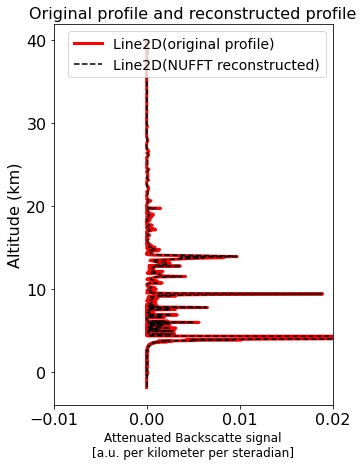

In [36]:
restore_time = NufftObj.solve(NUFT_profile,'cg', maxiter=100000)
restore_time2 = NufftObj.solve(NUFT_profile,'L1TVOLS', maxiter=3000,rho=1)
# pdb.set_trace()



# fig = plt.subplot(figsize=(5, 7))
fig, ax = plt.subplots(figsize=[5,7])

im1,=plt.plot(np.abs(tab532[i]), lidar_altitudes, 'r',label='original profile', linewidth=3)
im3,=plt.plot(np.abs(restore_time2), lidar_altitudes,'k--',label='NUFFT reconstructed', linewidth=1.5)
# im4,=plt.plot(np.abs(restore_time), lidar_altitudes, 'r:',label='conjugate_gradient_method')
plt.legend([im1, im3], fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)

plt.title('Original profile and reconstructed profile', fontsize=16)
plt.xlabel('Attenuated Backscatte signal\n[a.u. per kilometer per steradian]', fontsize=12)
plt.ylabel('Altitude (km)', fontsize=16)
plt.xlim([-0.01, 0.02])
plt.show()

NameError: ignored

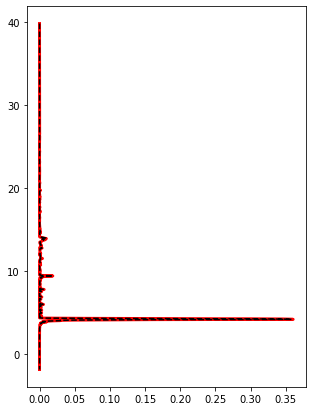

In [38]:
fig, ax = plt.subplots(figsize=[5,7])

im1,=plt.plot(np.abs(tab532[i]), lidar_altitudes, 'r',label='original profile', linewidth=3)
im3,=plt.plot(np.abs(restore_time2), lidar_altitudes,'k--',label='NUFFT reconstructed', linewidth=1.5)
# im4,=plt.plot(np.abs(restore_time), lidar_altitudes, 'r:',label='conjugate_gradient_method')
plt.legend([im1, im3, im4], fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)

plt.title('Original profile and reconstructed profile', fontsize=16)
plt.xlabel('Attenuated Backscatte signal\n[a.u. per kilometer per steradian]', fontsize=12)
plt.ylabel('Altitude (km)', fontsize=16)
plt.xlim([-0.01, 0.02])
plt.show()

## Con nube

4660
1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


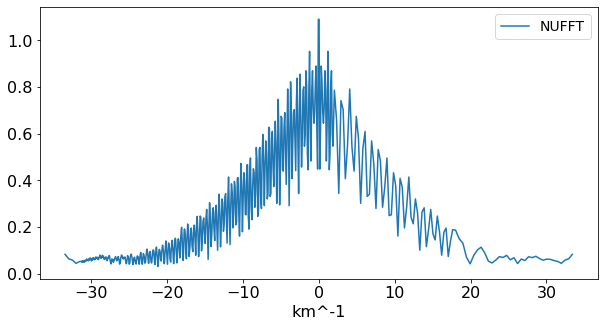

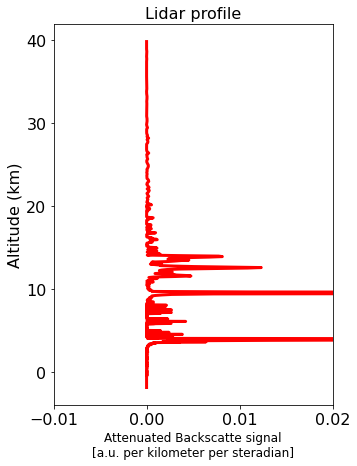

4662
1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


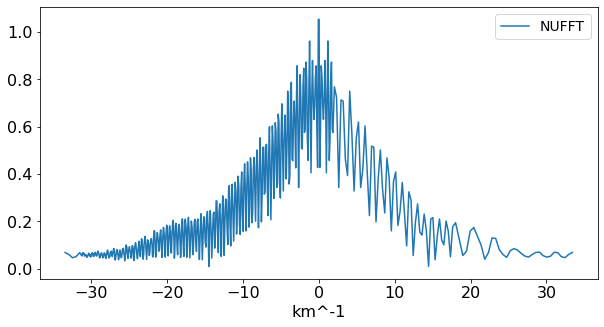

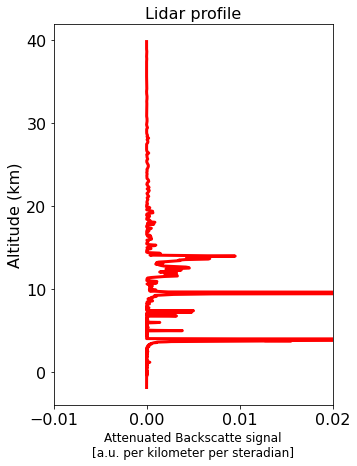

4664
0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


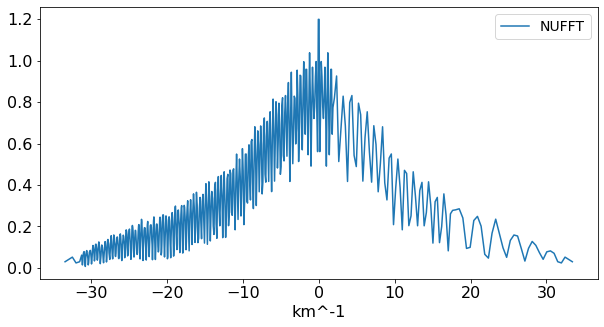

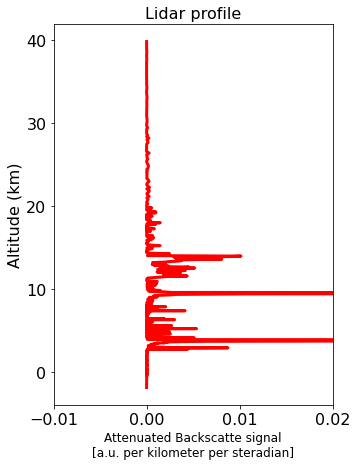

4666
1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


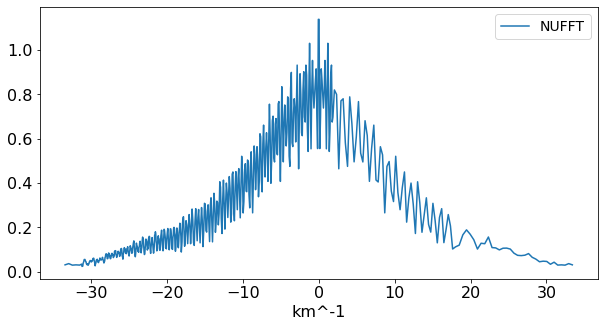

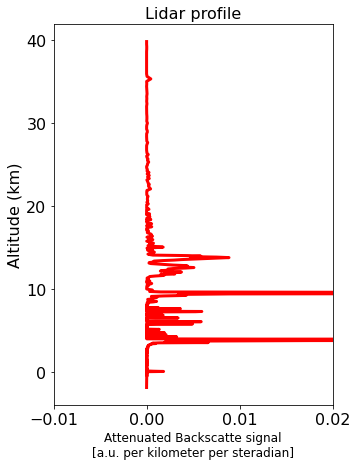

4668
1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


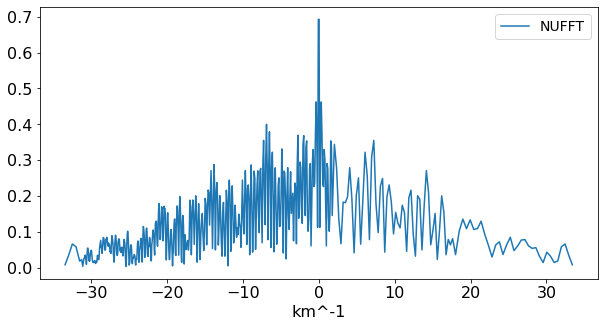

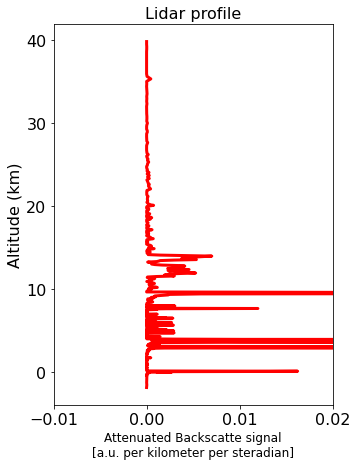

4670
0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


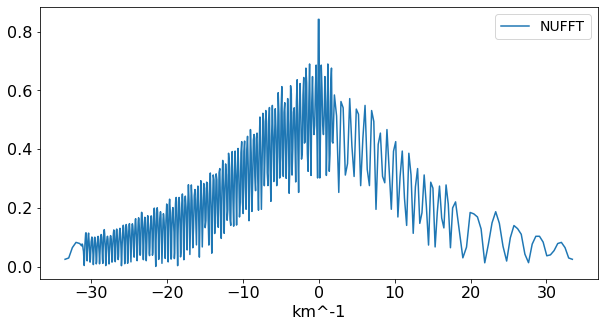

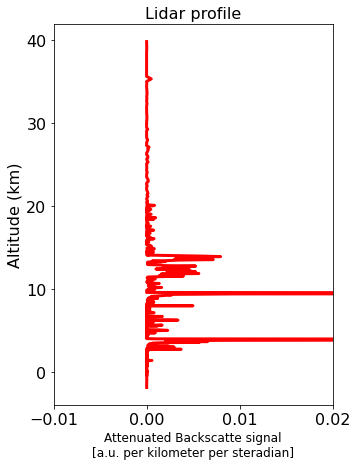

4672
1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


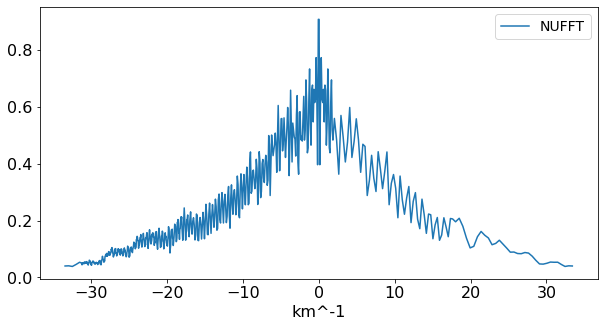

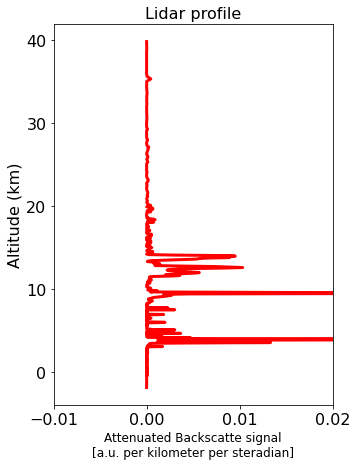

4674
1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


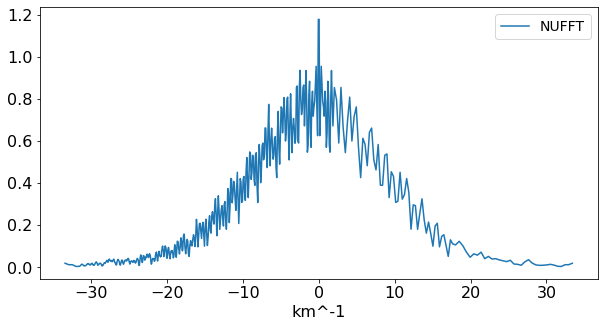

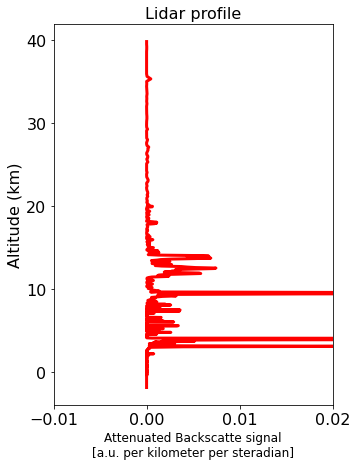

4676
0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


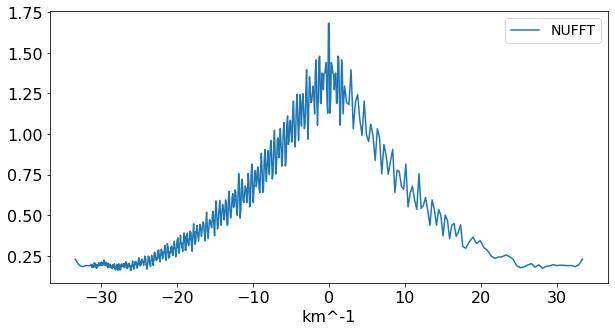

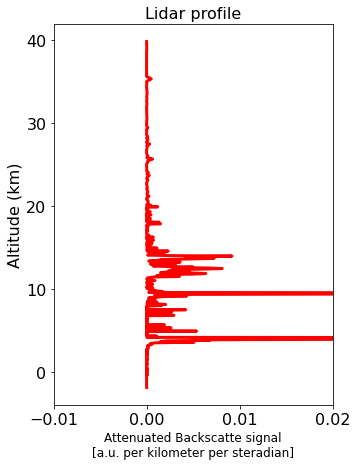

4678
1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


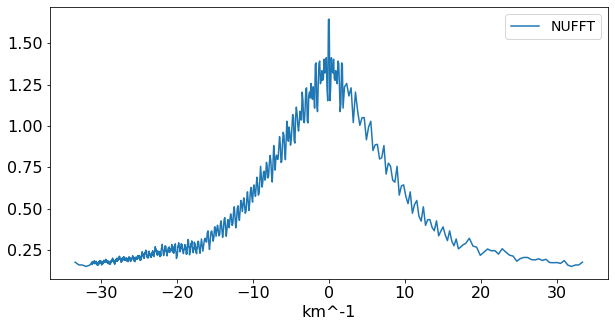

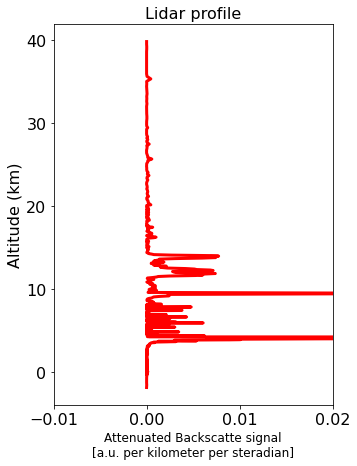

4680
1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


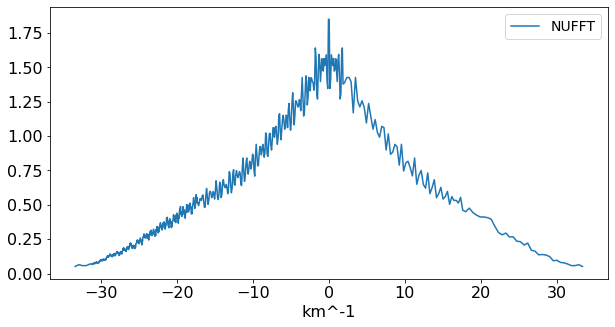

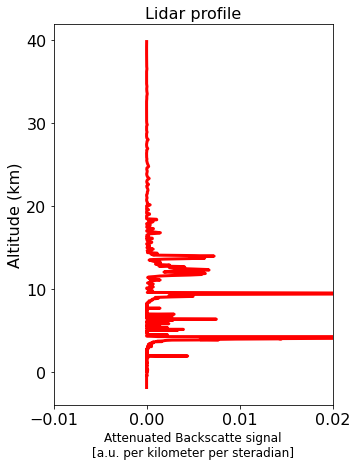

4682
0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


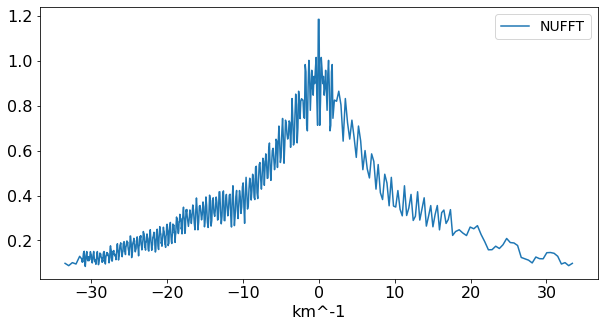

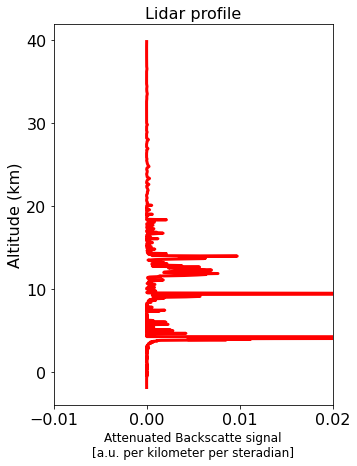

4684
1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


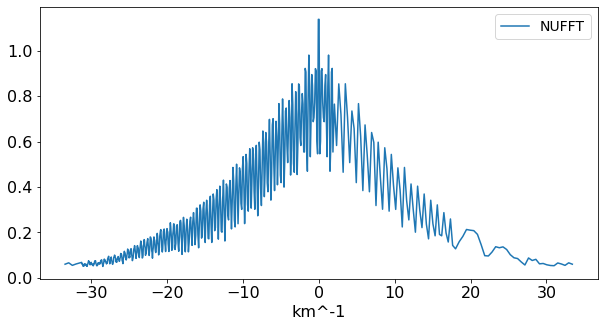

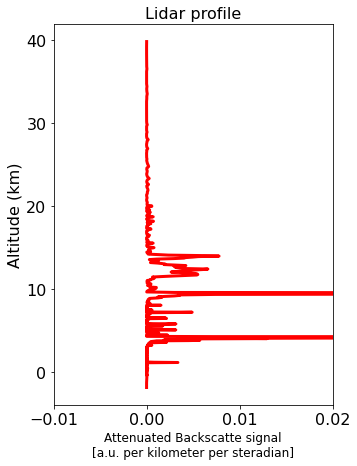

4686
1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


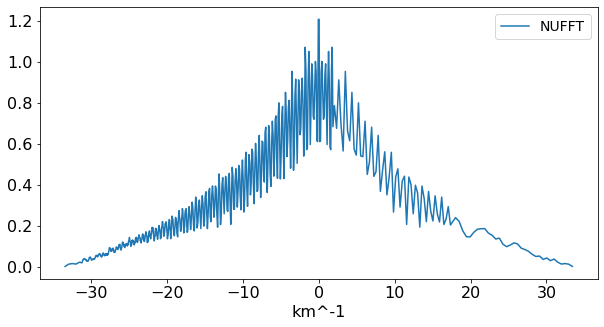

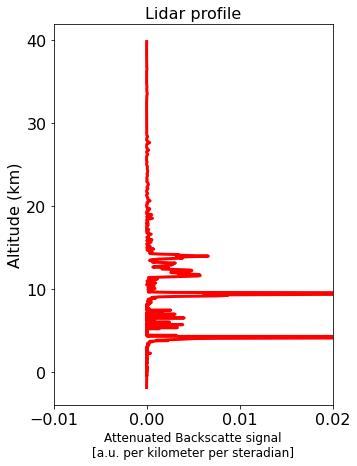

4688
0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


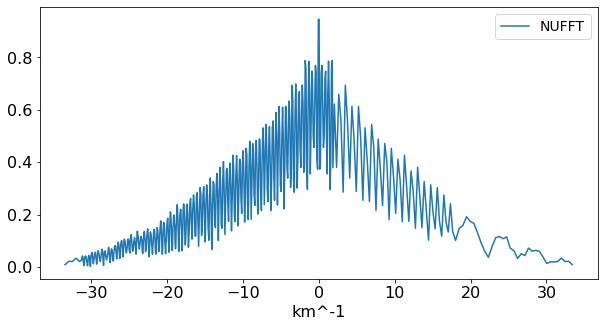

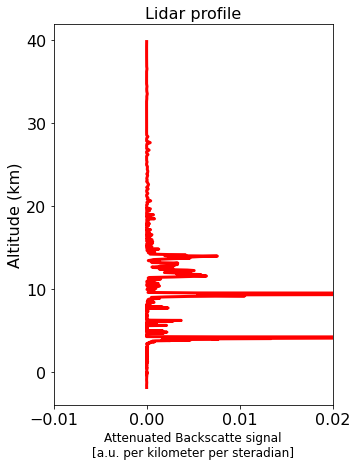

4690
0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


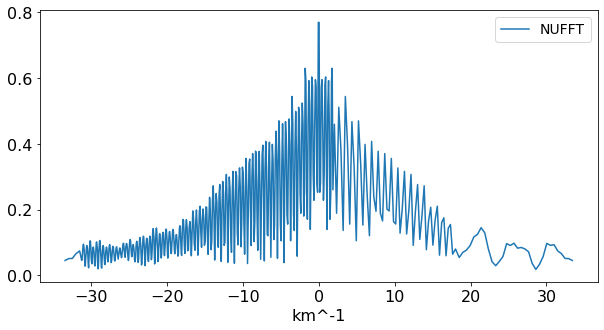

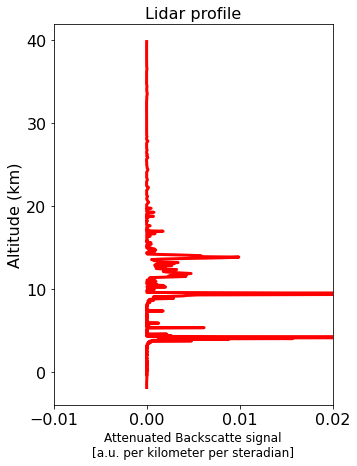

4692
1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


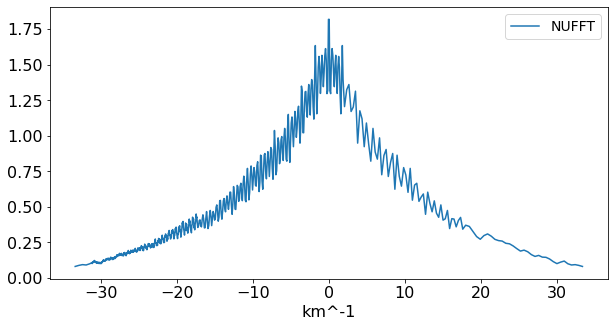

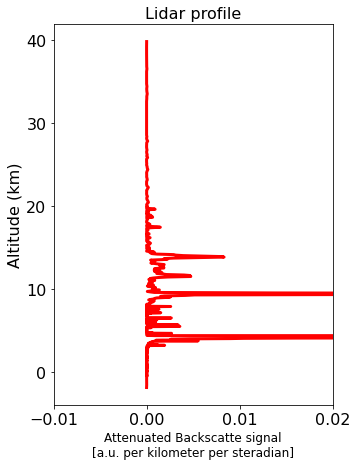

4694
0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


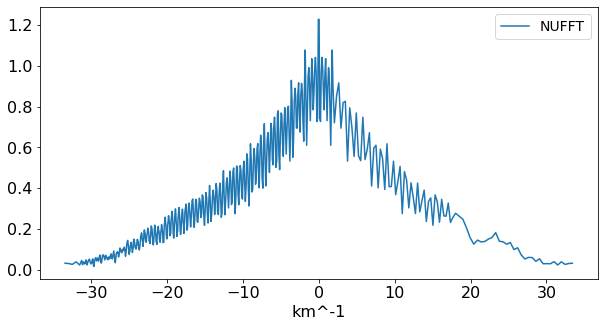

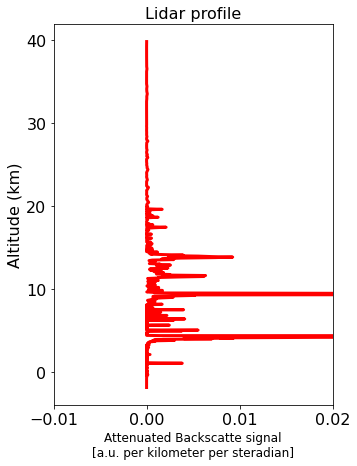

4696
0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


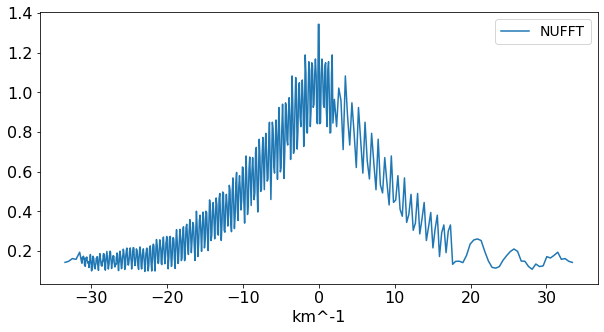

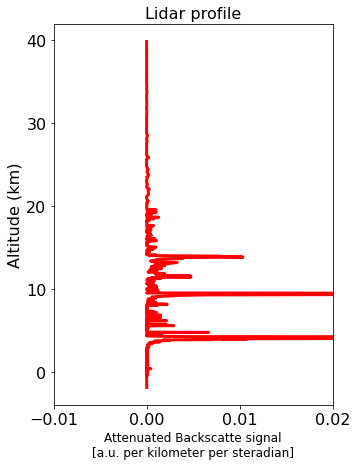

4698
1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


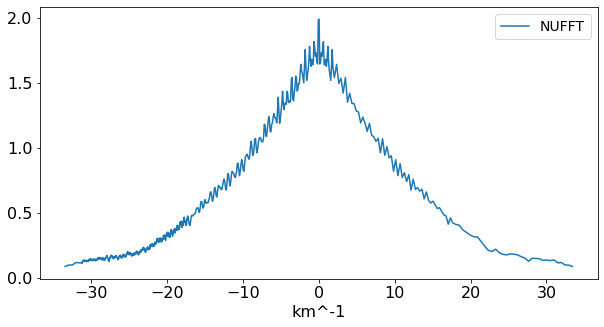

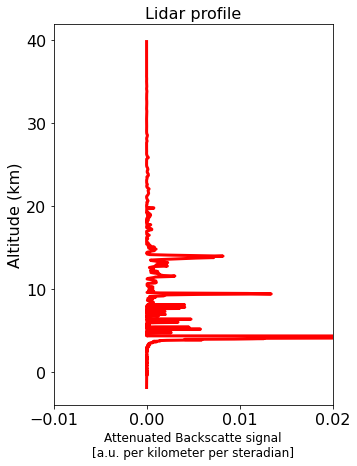

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'km^-1')

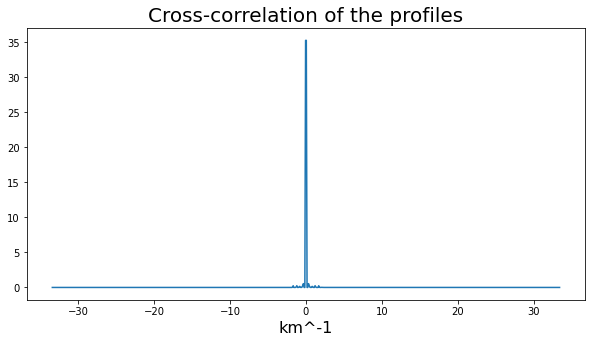

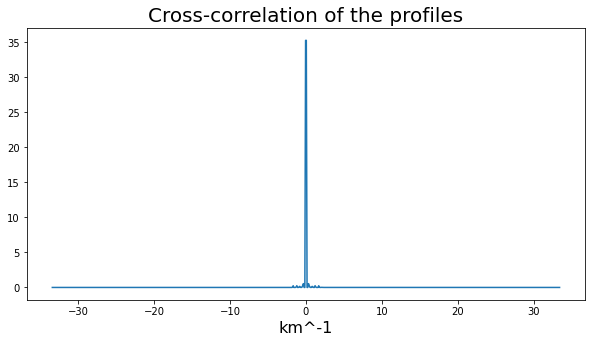

In [39]:
profiles = [i, i+1, i]

i = 4680

# pdb.set_trace()
FTS = np.ones(np.shape(tab532[0]))
# pdb.set_trace()

for j in np.arange(-20,20,2):
  print(i+j)
  print(np.isnan(tab532[i+j]).sum())
  tab532[i+j][np.isnan(tab532[i+j])] = 0


  NufftObj = NUFFT()
  # pdb.set_trace()
  om = np.reshape(np.array(lidar_altitudes), (np.shape(lidar_altitudes)[0], 1))
  om = (om - om.min()) / (om.max() - om.min())
  om = om*2*np.pi - np.pi
  # pdb.set_trace()

  Nd = (int(np.shape(lidar_altitudes)[0]), )
  Kd = (int(np.shape(lidar_altitudes)[0]), )
  # Nd = (256,)
  # Kd = (512,)
  Jd = (3,)
  NufftObj.plan(om, Nd, Kd, Jd)

  # fig = plt.figure(figsize=(10, 5))
  fig, ax = plt.subplots(figsize=[10,5])
  NUFT_profile = NufftObj.forward(tab532[i+j])

  FTS = FTS * np.sqrt(NUFT_profile * NUFT_profile.conjugate())

  freqs = om / om.max()
  freqs = freqs * (1/abs(np.diff(lidar_altitudes).max()))
  plt.plot(freqs,np.sqrt(NUFT_profile * NUFT_profile.conjugate()), label='NUFFT')
  # plt.plot(freqs,spec_profile, label='Python FFT')
  plt.legend(fontsize=14)

  # plt.title('Fourier transform of the profile', fontsize=16)
  plt.xlabel('km^-1', fontsize=16)
  ax.tick_params(axis='both', which='major', labelsize=16)
  ax.tick_params(axis='both', which='minor', labelsize=16)
  plt.show()

  restore_time = NufftObj.solve(NUFT_profile,'cg', maxiter=100000)
  restore_time2 = NufftObj.solve(NUFT_profile,'L1TVOLS', maxiter=3000,rho=1)
  # pdb.set_trace()



  # fig = plt.subplot(figsize=(5, 7))
  fig, ax = plt.subplots(figsize=[5,7])

  im1,=plt.plot(np.abs(tab532[i+j]), lidar_altitudes, 'r',label='original profile', linewidth=3)
  # im3,=plt.plot(np.abs(restore_time2), lidar_altitudes,'k--',label='NUFFT reconstructed', linewidth=1.5)
  # im4,=plt.plot(np.abs(restore_time), lidar_altitudes, 'r:',label='conjugate_gradient_method')
  # plt.legend([im1, im3], fontsize=14)

  ax.tick_params(axis='both', which='major', labelsize=16)
  ax.tick_params(axis='both', which='minor', labelsize=16)

  plt.title('Lidar profile', fontsize=16)
  plt.xlabel('Attenuated Backscatte signal\n[a.u. per kilometer per steradian]', fontsize=12)
  plt.ylabel('Altitude (km)', fontsize=16)
  plt.xlim([-0.01, 0.02])
  plt.show()
  
fig, ax = plt.subplots(figsize=[10,5])


plt.title('Cross-correlation of the profiles', fontsize=20)
plt.plot(freqs, FTS)

plt.xlabel('km^-1', fontsize=16)

# plt.ylim([0, 2e-6])
# plt.xlim([-5, 5])

fig, ax = plt.subplots(figsize=[10,5])


plt.title('Cross-correlation of the profiles', fontsize=20)
plt.plot(freqs, FTS)

plt.xlabel('km^-1', fontsize=16)
# plt.ylim([0, 2e-6])
# plt.xlim([-5, 5])

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-3.0, 3.0)

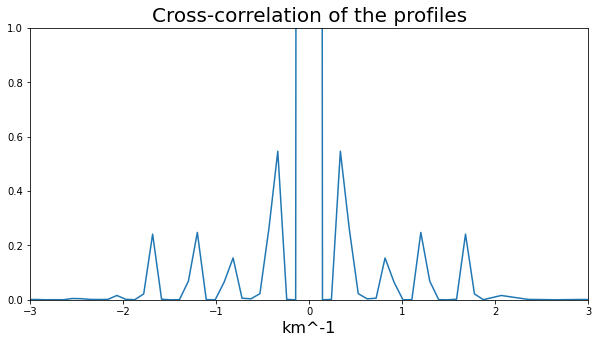

In [ ]:
fig, ax = plt.subplots(figsize=[10,5])


plt.title('Cross-correlation of the profiles', fontsize=20)
plt.plot(freqs, FTS)
plt.xlabel('km^-1', fontsize=16)

plt.ylim([0, 1e0])
plt.xlim([-3, 3])

## Sin nube

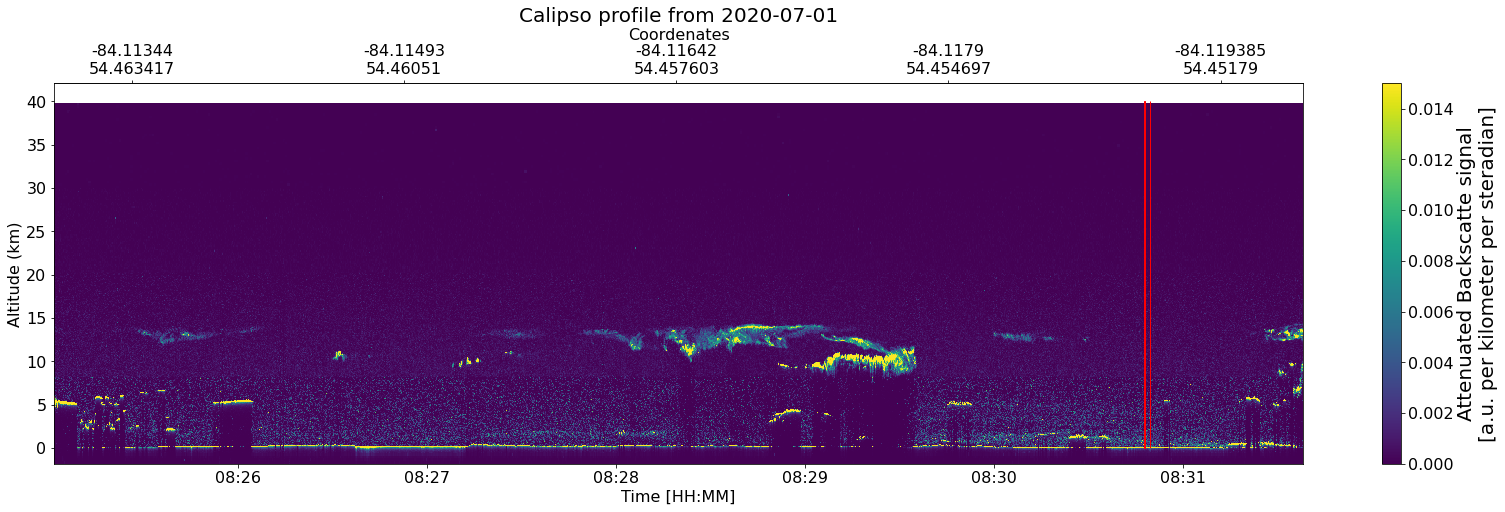

In [40]:
# fig = plt.figure(figsize=(15,6))
fig, ax = plt.subplots(figsize=[28,7])
# pdb.set_trace()
plt.title('Calipso profile from {date}'.format(date=dts[0].date().strftime('%Y-%m-%d')), fontsize=20)

plt.pcolormesh(dts[:I], lidar_altitudes, tab532[:I].T, vmin=0, vmax=0.015)
cbar = plt.colorbar()
cbar.set_label("Attenuated Backscatte signal\n[a.u. per kilometer per steradian]", fontsize=20)
cbar.ax.tick_params(labelsize=16)

i = 7000

secax = ax.secondary_xaxis('top')
secax.set_xlabel('Coordenates', fontsize=16)
secax.set_xticklabels(pos_labels, fontsize=16)

ax.set_xlabel('Time [HH:MM]', fontsize=16)
ax.set_ylabel('Altitude (km)', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)


myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)

# pdb.set_trace()
endTime = dts[6980] + dt.timedelta(seconds=0.1)
start = mpl.dates.date2num(dts[6980])
end = mpl.dates.date2num(endTime)
width = end - start
rect = mpl.patches.Rectangle((start, 0), width, 40, linewidth=1,color='red',fill=False)
ax.add_patch(rect)

endTime = dts[7016] + dt.timedelta(seconds=0.1)
start = mpl.dates.date2num(dts[7016])
end = mpl.dates.date2num(endTime)
width = end - start
rect = mpl.patches.Rectangle((start, 0), width, 40, linewidth=1,color='red',fill=False)
ax.add_patch(rect)

# plt.ylim([0, 5])


6980
0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


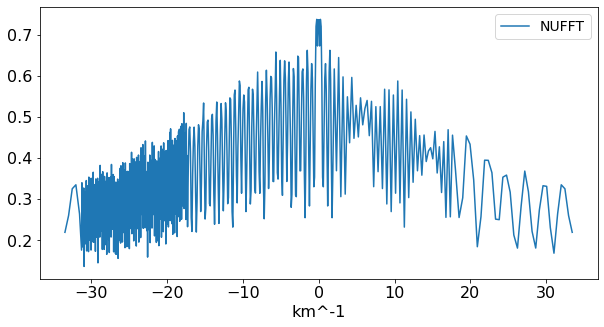

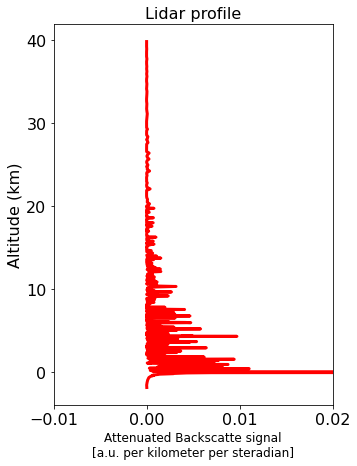

6984
0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


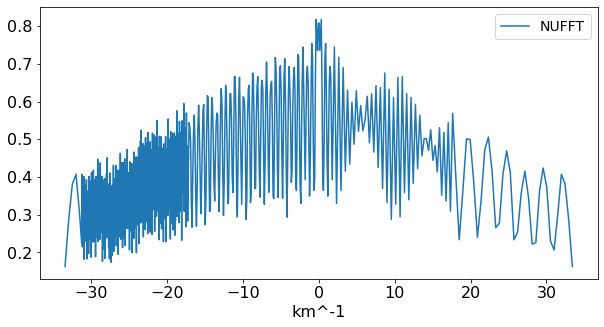

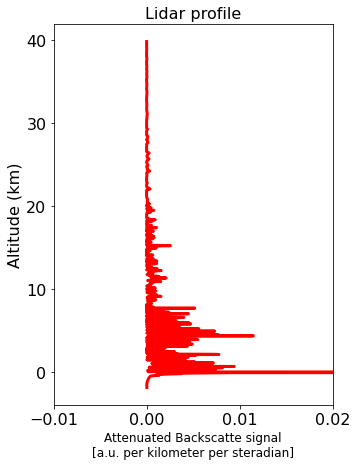

6988
0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


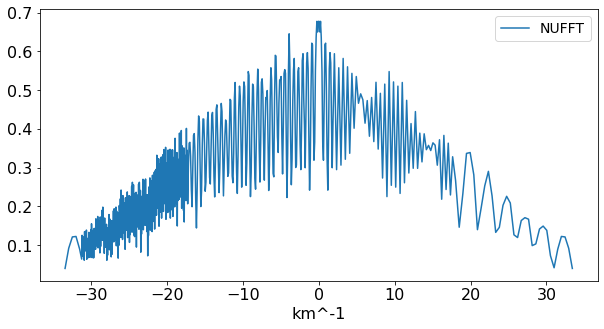

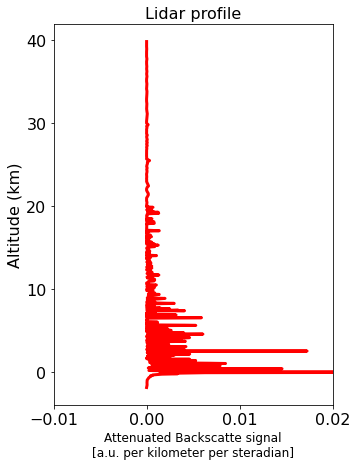

6992
0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


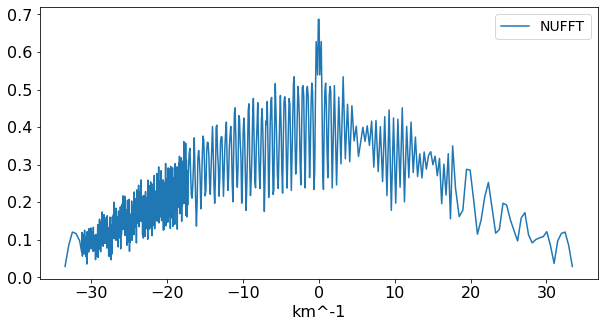

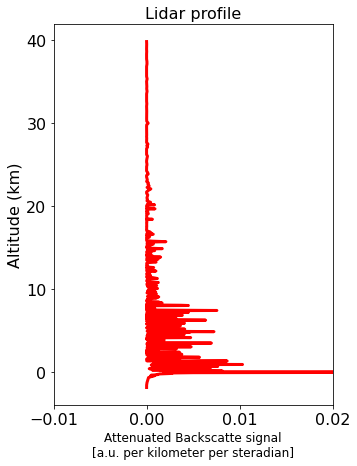

6996
0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


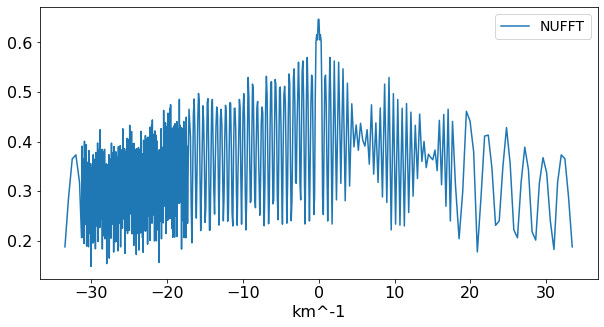

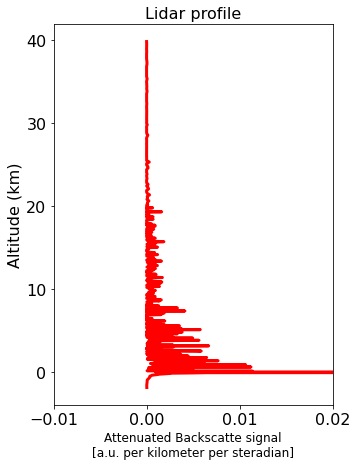

7000
0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


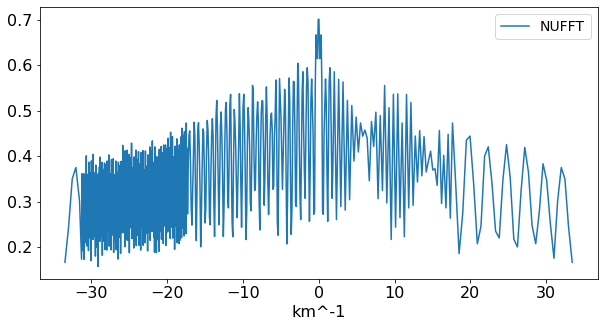

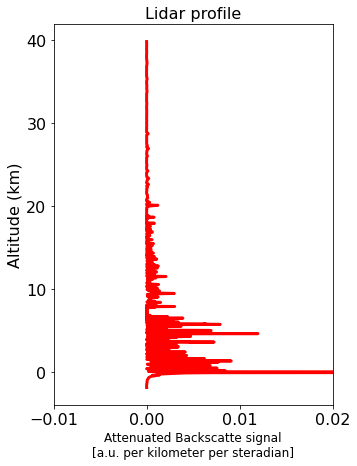

7004
0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


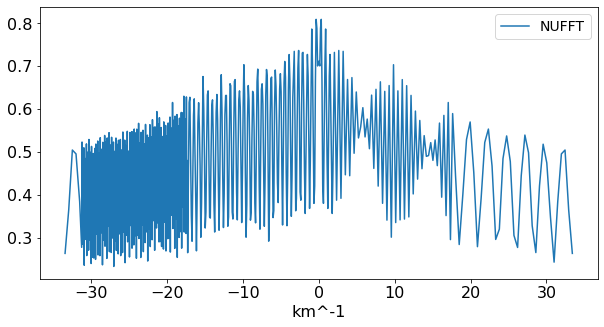

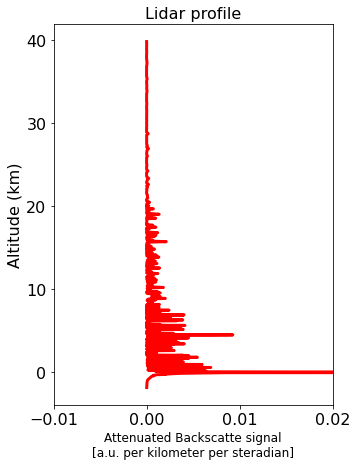

7008
0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


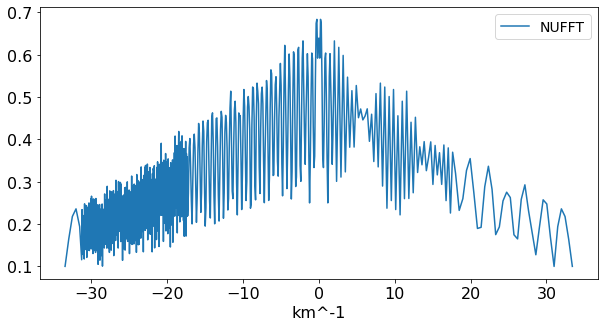

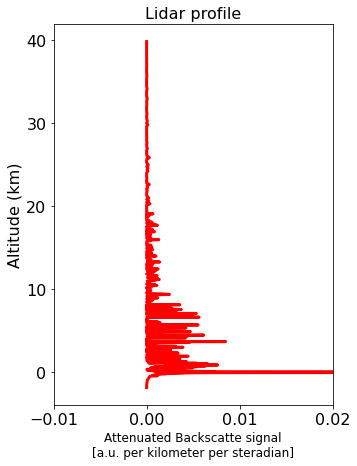

7012
0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


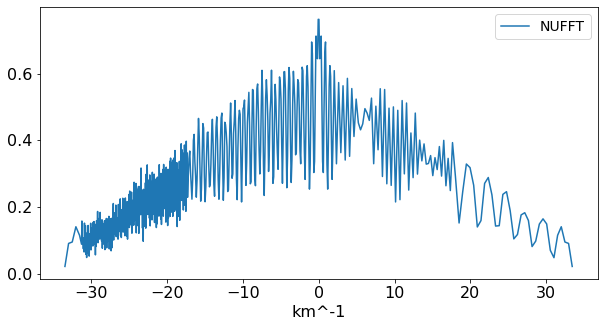

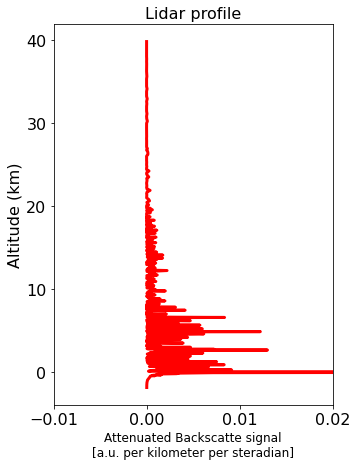

7016
0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


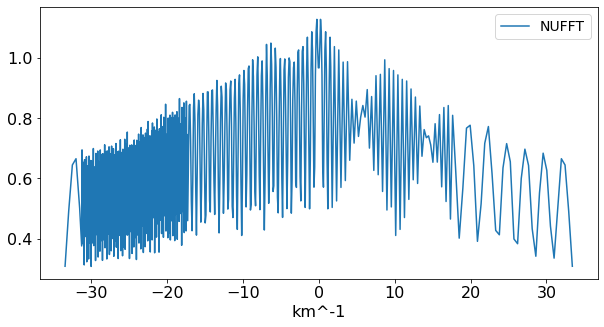

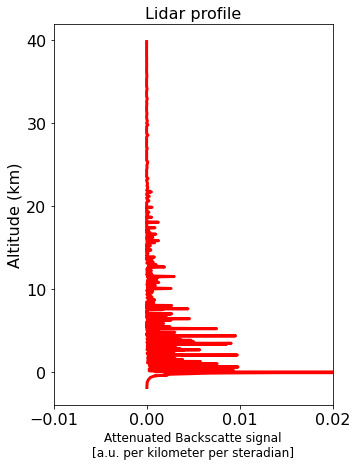

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'km^-1')

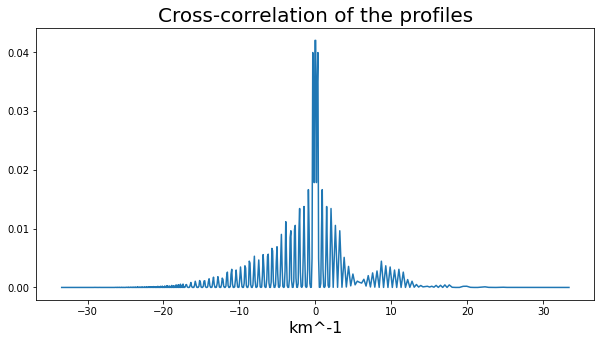

In [42]:
profiles = [i, i+1, i]

i = 7000

# pdb.set_trace()
FTS = np.ones(np.shape(tab532[0]))
# pdb.set_trace()

for j in np.arange(-20,20,4):
  print(i+j)
  print(np.isnan(tab532[i+j]).sum())
  tab532[i+j][np.isnan(tab532[i+j])] = 0


  NufftObj = NUFFT()
  # pdb.set_trace()
  om = np.reshape(np.array(lidar_altitudes), (np.shape(lidar_altitudes)[0], 1))
  om = (om - om.min()) / (om.max() - om.min())
  om = om*2*np.pi - np.pi
  # pdb.set_trace()

  Nd = (int(np.shape(lidar_altitudes)[0]), )
  Kd = (int(np.shape(lidar_altitudes)[0]), )
  # Nd = (256,)
  # Kd = (512,)
  Jd = (3,)
  NufftObj.plan(om, Nd, Kd, Jd)

  # fig = plt.figure(figsize=(10, 5))
  fig, ax = plt.subplots(figsize=[10,5])
  NUFT_profile = NufftObj.forward(tab532[i+j])

  FTS = FTS * np.sqrt(NUFT_profile * NUFT_profile.conjugate())

  freqs = om / om.max()
  freqs = freqs * (1/abs(np.diff(lidar_altitudes).max()))
  plt.plot(freqs,np.sqrt(NUFT_profile * NUFT_profile.conjugate()), label='NUFFT')
  # plt.plot(freqs,spec_profile, label='Python FFT')
  plt.legend(fontsize=14)

  # plt.title('Fourier transform of the profile', fontsize=16)
  plt.xlabel('km^-1', fontsize=16)
  ax.tick_params(axis='both', which='major', labelsize=16)
  ax.tick_params(axis='both', which='minor', labelsize=16)
  plt.show()

  restore_time = NufftObj.solve(NUFT_profile,'cg', maxiter=100000)
  restore_time2 = NufftObj.solve(NUFT_profile,'L1TVOLS', maxiter=3000,rho=1)
  # pdb.set_trace()



  # fig = plt.subplot(figsize=(5, 7))
  fig, ax = plt.subplots(figsize=[5,7])

  im1,=plt.plot(np.abs(tab532[i+j]), lidar_altitudes, 'r',label='original profile', linewidth=3)
  # im3,=plt.plot(np.abs(restore_time2), lidar_altitudes,'k--',label='NUFFT reconstructed', linewidth=1.5)
  # im4,=plt.plot(np.abs(restore_time), lidar_altitudes, 'r:',label='conjugate_gradient_method')
  # plt.legend([im1, im3], fontsize=14)

  ax.tick_params(axis='both', which='major', labelsize=16)
  ax.tick_params(axis='both', which='minor', labelsize=16)

  plt.title('Lidar profile', fontsize=16)
  plt.xlabel('Attenuated Backscatte signal\n[a.u. per kilometer per steradian]', fontsize=12)
  plt.ylabel('Altitude (km)', fontsize=16)
  plt.xlim([-0.01, 0.02])
  plt.show()

  
fig, ax = plt.subplots(figsize=[10,5])


plt.title('Cross-correlation of the profiles', fontsize=20)
plt.plot(freqs, FTS)
plt.xlabel('km^-1', fontsize=16)

# plt.ylim([0, 2e-6])
# plt.xlim([-5, 5])

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-20.0, 20.0)

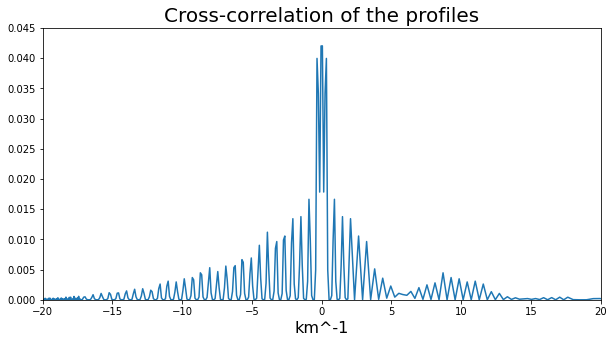

In [ ]:
fig, ax = plt.subplots(figsize=[10,5])


plt.title('Cross-correlation of the profiles', fontsize=20)
plt.plot(freqs, FTS)
plt.xlabel('km^-1', fontsize=16)

plt.ylim([0, 4.5e-2])
plt.xlim([-20, 20])